In [4]:
%matplotlib inline
import operator
import talib
import numpy as np
import pandas as pd
import time
from datetime import datetime, date, timedelta

import statsmodels
from statsmodels.tsa.stattools import adfuller

import seaborn
import matplotlib.pyplot as plt

from db import (db, prices, get_performance, 
                prepare_pair, get_prices_yahoo, months_generator)

pd.set_option('display.max_rows', 500) # default 30
pd.set_option('display.max_columns', 80) # default 20
pd.set_option('max_colwidth', 100) # default 40

def zscore_std(series, name="z-score"):
    return ((series - series.mean()) / np.std(series)).rename(name)

def zscore_std_np(a):
    b = (a - a.mean()) / np.std(a)
    b[np.isnan(b)] = 0
    return b

In [13]:
# get listed symbols with price above $10; average volume more than 500K; atr(13) > 0.4
sql = "SELECT symbol FROM listed WHERE is_listed AND price > 10 AND avg_volume > 500000 AND atr > 0.4 ORDER BY symbol"
r = db.query(sql)
listed_symbols = [s[0] for s in r]
symbol_list = listed_symbols[:]  # FIXME: for quick run only 50 assets

analyze_date = datetime(2015, 1, 1)  # last date
analyze_length = 370

all_prices = prices(symbol_list, analyze_date, analyze_length)  # 360
symbol_prices = {s: np.array([x[5] for x in all_prices if x[0] == s]) for s in symbol_list} 
len(listed_symbols), len(symbol_prices)

(1298, 1298)

# Подготовка цен

* Проверяем длину истории и берем минимум 95% активов.
* Все истории приводим к одной длине и отбрасываем короткие.
* Все истории цен приводим к относительным величинам.
* Удаляем все стационарные истории.

In [14]:
# get all lengths
all_lengths = [len(p) for s, p in symbol_prices.items()]
# get thresghold length for minimum 5% items
length_limit = int(np.percentile(all_lengths, 10))
# get cutted price histories
symbol_prices = {s: p[-length_limit:] for s, p in symbol_prices.items() if len(p) >= length_limit} 
# get performance for cutted price histories
symbol_performance = {s: get_performance(p[-length_limit:]) for s, p in symbol_prices.items() if len(p) >= length_limit} 

# check cointegration and remove found symbols
to_delete = []
for s, p in symbol_performance.items():
    result = adfuller(p)
    score = result[0]
    pvalue = result[1]
    crit = result[4]
    #score, pvalue, score < crit['5%']
    if score < crit['5%']:
        # cointegrated
        to_delete.append(s)
        pass
if to_delete:
    for s in to_delete:
        del symbol_performance[s]

'Total stocks {0} with minimum length {1}. Removed {2} cointegrated histories.'.format(len(symbol_performance), length_limit, len(to_delete))

'Total stocks 1138 with minimum length 255. Removed 54 cointegrated histories.'

## Поиск пар с помощью средних

In [15]:
def get_diff(y):
    """
    Метод наименьших квадратов
    для поиска разницы между парами.
    """
    x = np.array([i for i in range(len(y))])
    arr = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(arr, y)[0]
    #print(m, c)
    return c
    
def check_coint_parts(X):
    """
    Проверяем стационарность на коротких отрезках.
    """
    parts = 4 if len(X) > 300 else 2
    step_size = len(X) // parts
    res = dict()
    for step in range(parts):
        begin = step * step_size
        end = step * step_size + step_size
        result = adfuller(X[begin:end])
        score, pvalue, crit = result[0], result[1], result[4]
        res[step] = {
            'begin': begin, 
            'end': end, 
            'coint': score < crit['5%'], 
            'pvalue': pvalue
        }
    return res
    
def find_pairs_ema_upgraded(symbol_prices, need_preparation=False):
    n = len(symbol_prices)
    symbols = list(symbol_prices.keys())
    pairs = []
    
    for i in range(n):
        for j in range(i+1, n):
            S1 = symbol_prices[symbols[i]]
            S2 = symbol_prices[symbols[j]]
            
            # подготавливаем ряды, если необходимо
            if need_preparation:
                S1, S2 = prepare_vectors(S1, S2, to_performance=True)
            
            # получаем скользящие средние
            period = 50
            ema1 = talib.EMA(S1, timeperiod=period)
            ema2 = talib.EMA(S2, timeperiod=period)

            spread = (ema1[period-1:] - ema2[period-1:])
            # среднее значение спреда MA
            spread_mean = abs(spread).mean()
            # медиана спреда MA
            spread_median = np.median(abs(spread))
            # максимальное значение 70% значений по модулю спреда MA
            spread_percentile = np.percentile(abs(spread), 70)  
            
            # добавляем пары со средним значением спреда EMA50 < 3
            # ИЛИ медианой спреда EMA50 < 3
            # ИЛИ процентилем 70% от спреда EMA50 < 3
            if spread_percentile < 3:
                # проверяем стационарность сигнальной линии zscore_std_np(S1-S2)
                result = adfuller(S1-S2)
                score, pvalue, crit = result[0], result[1], result[4]
                
                # параметры спреда
                spread_params = {
                    'median': spread_median, 
                    'mean': spread_mean, 
                    'percentile': spread_percentile, 
                    'pvalue': pvalue, 
                    'coint': score < crit['5%']    
                }                
                
                # проверяем стационарность коротких промежутков
                short_parts = check_coint_parts(S1-S2)
                
                pairs.append((symbols[i], symbols[j], 
                              spread_params, 
                              short_parts))
                
    return pairs

In [16]:
"""
Искать только по относительным величинам, так как для цен порог разницы между средними всегда будет меняться
"""
begin = time.time()
pairs = find_pairs_ema_upgraded(symbol_performance)
len(pairs), (time.time() - begin)/60

/home/alex/env/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:712: RuntimeWarning: divide by zero encountered in log
  (self.endog - np.dot(self.exog,params)))) -\
/home/alex/env/lib/python3.5/site-packages/statsmodels/base/model.py:978: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


(9182, 5.288575792312622)

# Analyze found pairs

Сбор наблюдений для найденных пар и фильтр.

In [20]:
def check_future_coint(s1, s2):
    analyze_date = datetime(2015, 7, 1)
    analyze_length = 370    
    symbol_list = [s1, s2]
    all_prices = prices(list(symbol_list), analyze_date, analyze_length)
    symbol_test_prices = {s: np.array([x[5] for x in all_prices if x[0] == s]) for s in symbol_list}
    S1 = symbol_test_prices[s1][-255:]
    S2 = symbol_test_prices[s2][-255:]
    result = adfuller(S1-S2)
    score, pvalue, crit = result[0], result[1], result[4]
    return score < crit['5%']

results = []
for s1, s2, spread_params, short_parts in pairs:
    res = {
        'Symbol1': s1,
        'Symbol2': s2,
        'Median': spread_params['median'],
        'Mean': spread_params['mean'],
        'Percentile': spread_params['percentile'],
        'pvalue': spread_params['pvalue'],
        'coint': spread_params['coint'],
        'part_size': short_parts[0]['end'] - short_parts[0]['begin'],
        'part1': short_parts[0]['coint'],
        'part2': short_parts[1]['coint'],
        'part3': short_parts[2]['coint'] if 2 in short_parts else '',
        'part4': short_parts[3]['coint'] if 3 in short_parts else '',
        #'future': check_future_coint(s1, s2) if short_parts[0]['coint'] and short_parts[1]['coint'] else False,
    }
    P1, P2 = symbol_performance[s1], symbol_performance[s2]
    #P1, P2 = symbol_prices[s1], symbol_prices[s2]
    spread = P1 - P2
    
    res['std'] = np.std(spread)
    #res['std(-40)'] = np.std(spread[-40:])
    
    z = ((spread - spread.mean()) / np.std(spread))    
    res['x(0)'] = len(z[abs(np.insert(np.diff(np.sign(z)), 0, 0)) == 2])
    res['x(-1)'] = len(z[abs(np.insert(np.diff(np.sign(z+1)), 0, 0)) == 2]) 
    res['x(+1)'] = len(z[abs(np.insert(np.diff(np.sign(z-1)), 0, 0)) == 2])
    results.append(res)
    
d = pd.DataFrame(results)

# фильтр низкой сигмы
fltr = d['std'] > 0.7
# только стационарные
fltr = (fltr) & (d['coint'] == True)
# фильтр стационарных коротких частей
fltr = (fltr) & (d['part1'] == True) & (d['part2'] == True)
#fltr = (fltr) & (d['part3'] == True) & (d['part4'] == True)

#fltr = (fltr) & (d['future'] == True)
#fltr = (fltr) & (d['Symbol2'] == 'XRT')

print(len(d[fltr]))
d[fltr].sort_values(['x(0)'], ascending=False)

91


/home/alex/env/lib/python3.5/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in true_divide


Mean    Median  Percentile Symbol1 Symbol2 coint part1 part2 part3  \
107   1.005720  1.107066    1.350120     GPC     PNW  True  True  True         
4829  2.452033  2.477510    2.762999     TJX     SBH  True  True  True         
8699  0.492738  0.377834    0.627629     ROK     MOS  True  True  True         
7193  1.149845  0.914117    1.607023     AET     SMH  True  True  True         
5732  1.990763  2.492852    2.796494     HLT     EFX  True  True  True         
7613  1.291119  1.263022    1.785186    NXPI     SIG  True  True  True         
6886  2.407423  2.350019    2.711674       Q    BIIB  True  True  True         
2806  1.259057  1.075634    1.790145     GSM     BWA  True  True  True         
8434  1.021240  0.963145    1.464117     JWN     MJN  True  True  True         
537   2.034885  2.214772    2.558715      IP     DXJ  True  True  True         
1167  1.308378  1.431918    1.918164      CA    FOSL  True  True  True         
4876  1.125534  1.026634    1.311926     ABT     HLT  True  True  True         
9162  1.685670  1.543712    2.419596     PPL      LM  True  True  True         
455   2.004863  2.047007    2.370710     RAI     TSM  True  True  True         
3307  2.144906  2.237957    2.990267     THS     SRE  True  True  True         
4097  0.707194  0.741739    0.882856       K    ORCL  True  True  True         
859   1.081133  0.791253    1.060475      PF     AWK  True  True  True         
1573  1.694202  1.863407    2.127252     BPL     NGG  True  True  True         
1886  0.865729  0.713228    1.155712     PBI     TKR  True  True  True         
7346  1.755461  1.634946    2.333975      DG     NWL  True  True  True         
465   1.803454  1.761411    2.535266     RAI     HUM  True  True  True         
4889  0.582949  0.521861    0.796539     ABT     QQQ  True  True  True         
7280  1.711864  1.742579    2.377919    VOYA     FHN  True  True  True         
5901  1.471954  1.290687    1.729599     TXN     MDT  True  True  True         
6271  1.312463  1.164438    1.534255     CAA     LUK  True  True  True         
2979  1.316877  1.330018    1.534281     IYF     SYY  True  True  True         
3917  2.537027  2.620338    2.827426     SSO     SMH  True  True  True         
7469  2.002428  2.325394    2.546826     DCT      WR  True  True  True         
8371  2.148634  1.719589    2.784225     CMS    CUBE  True  True  True         
3674  2.108958  2.231188    2.842514      IT    COST  True  True  True         
6491  1.826832  1.654863    2.314084     HLS     MJN  True  True  True         
1969  0.931654  0.752715    1.091595     ACN     WBS  True  True  True         
8398  0.775944  0.750776    0.940035     BUD     AIG  True  True  True         
1550  1.378810  1.309446    1.594560     BPL     NVS  True  True  True         
219   2.384416  2.276449    2.737852     RPM     DGX  True  True  True         
8785  2.384364  2.289476    2.977418    PFPT    DXCM  True  True  True         
5294  1.685712  1.470093    2.012609     CNQ     CXO  True  True  True         
5491  1.811009  1.738975    2.352495     KMI    SYMC  True  True  True         
989   1.299492  0.782511    1.333028     CEB    FOSL  True  True  True         
3334  1.896327  1.647339    2.535085     NSC     MCO  True  True  True         
340   1.927997  1.734227    2.493915     PNW     NOC  True  True  True         
3863  1.460745  1.119778    2.100463    INTU    VOYA  True  True  True         
5443  1.518649  1.527057    1.784902     SYY     VFH  True  True  True         
8743  1.848247  2.027386    2.759934     LHO     SNA  True  True  True         
2406  1.138086  0.858135    1.514809     MAA     OFC  True  True  True         
6765  1.707991  1.620646    2.208284     UGI     UNP  True  True  True         
3673  2.067999  2.052853    2.842660      IT     ADP  True  True  True         
9012  0.826343  0.857254    1.156935     ENB      LH  True  True  True         
3353  1.136257  1.056110    1.434169     NSC     DFS  True  True  True         
864   1.77

In [17]:
analyze_length = 730
# 2016
analyze_date = datetime(2017, 1, 1)
#pair = ('EQY', 'T')
pair = ('DIA', 'SLB')
# 2015
analyze_date = datetime(2016, 1, 1)
#pair = ('DRE', 'O')
#pair = ('CIT', 'STT')
#pair = ('H', 'MMP')

analyze_length = 370
analyze_date = datetime(2016, 1, 1)
pair = ('SSO', 'SMH')

symbol_list = pair
all_prices = prices(list(symbol_list), analyze_date, analyze_length)
symbol_test_prices = {s: np.array([x[5] for x in all_prices if x[0] == s]) for s in symbol_list}
symbol_dates = {s: np.array([x[1] for x in all_prices if x[0] == s]) for s in symbol_list}

pair

('SSO', 'SMH')

Score=-2.9556; P-value=0.0393; Cointegrated=True; Crit[5%]=-2.8730 
Spread mean=1.60463; Spread median=1.35811; Percentile 80%=2.43535;


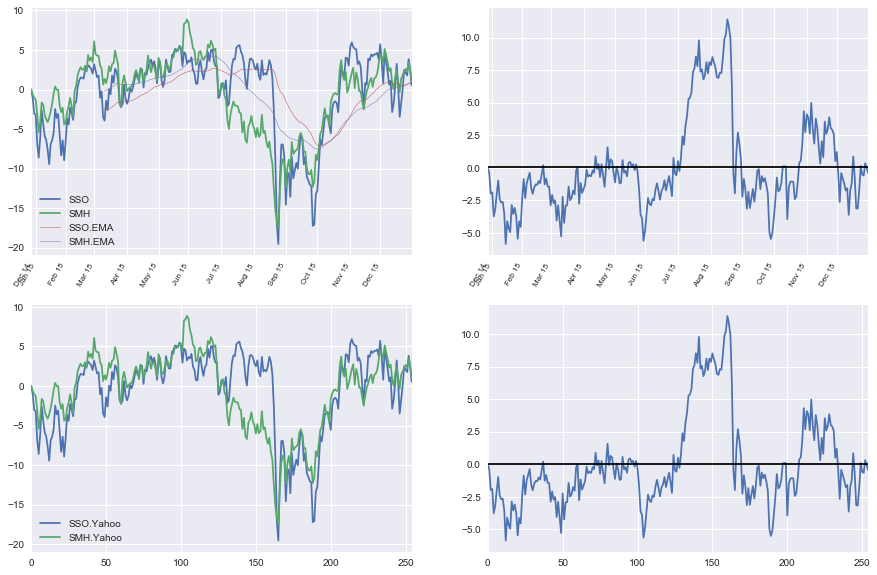

In [18]:
S1 = symbol_test_prices[pair[0]]
S2 = symbol_test_prices[pair[1]]

yprices = get_prices_yahoo([pair[0], pair[1]], dt_end=analyze_date)
Y1 = yprices[pair[0]].as_matrix()[-length_limit:]
Y2 = yprices[pair[1]].as_matrix()[-length_limit:]

# подготавливаем ряды
X, Y = prepare_pair(S1, S2, to_performance=True)
YX, YY = prepare_pair(Y1, Y2, to_performance=True)

period = 50
ema1 = talib.EMA(X, timeperiod=period)
ema2 = talib.EMA(Y, timeperiod=period)

# расчеты
diff = (ema1[period-1:] - ema2[period-1:])
diff_mean = abs(diff).mean()
diff_median = np.median(abs(diff))
diff_percentile = np.percentile(abs(diff), 80)

# prepare charts
X = pd.Series(X, name=pair[0])
Y = pd.Series(Y, name=pair[1])
YX = pd.Series(YX, name=pair[0] + '.Yahoo')
YY = pd.Series(YY, name=pair[1] + '.Yahoo')
X_ema = pd.Series(ema1, name=pair[0] + '.EMA')
Y_ema = pd.Series(ema2, name=pair[1] + '.EMA')

# xticks
dates = symbol_dates[pair[0]][-len(X):]
months = list(months_generator(dates))
xticks = [i for i in range(0, len(X)) if dates[i] in months]
xticklabels = [dt.strftime('%b %y') for dt in months]

# draw performance and MAs
fig, axs = plt.subplots(2,2, figsize=(15, 10))
pd.concat([X, Y], axis=1).plot(xticks=xticks, ax=axs[0][0]) # Performance
pd.concat([X_ema, Y_ema], axis=1).plot(ax=axs[0][0], linewidth=0.5) # SMA50
# xtick labels
axs[0][0].set_xticklabels(xticklabels, size=8, rotation=60, ha='right')

# draw spread
diff_series = pd.Series(X - Y, name='-'.join(pair))
diff_series.plot(xticks=xticks, ax=axs[0][1])
axs[0][1].axhline(diff_series.mean(), color='black')
# xtick labels
axs[0][1].set_xticklabels(xticklabels, size=8, rotation=60, ha='right')

# Yahoo.Finance for comparison
pd.concat([YX, YY], axis=1).plot(ax=axs[1][0]) # Performance
Ydiff_series = pd.Series(YX - YY, name='-'.join(pair))
Ydiff_series.plot(ax=axs[1][1])
axs[1][1].axhline(Ydiff_series.mean(), color='black')

result = adfuller(X-Y)
score, pvalue, crit = result[0], result[1], result[4]
print(
    'Score={0:.4f}; P-value={1:.4f}; Cointegrated={2}; Crit[5%]={3:.4f}'.format(score, pvalue, score < crit['5%'], crit['5%']),
    '\nSpread mean={0:.5f}; Spread median={1:.5f}; Percentile 80%={2:.5f};'.format(diff_mean, diff_median, diff_percentile)
)

(255,)

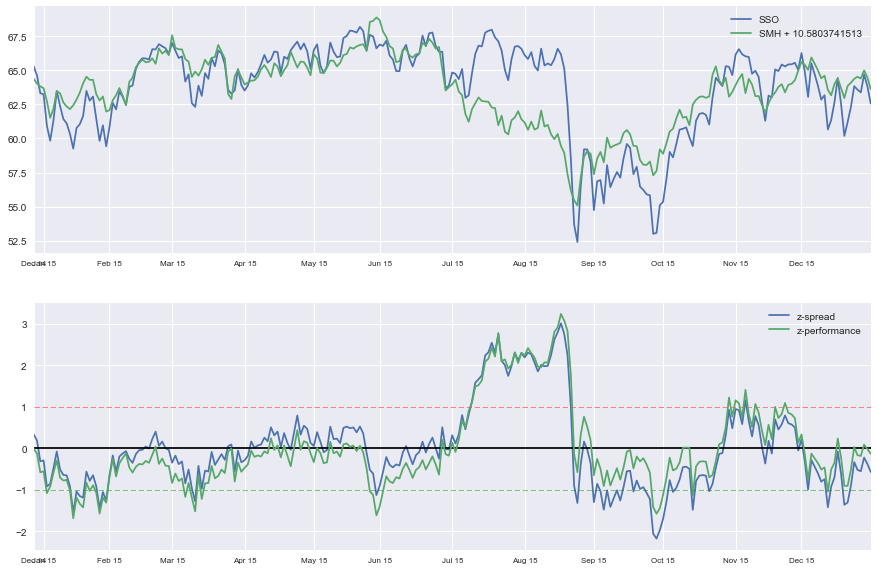

In [19]:
# Draw prices with z-score 
P1, P2 = prepare_pair(S1, S2, to_performance=False)

assets_diff = get_diff(P1 - P2)

coef_idx = -1 # 0/-1
ratio = S1[coef_idx]/S2[coef_idx]
P1 = pd.Series(P1, name=pair[0]) # приводим к одной цене по первому отношению
#P2 = pd.Series(P2, name=pair[1] + ' x ' + str(ratio))
P2 = pd.Series(P2, name=pair[1] + ' + ' + str(assets_diff))

# convert to same price
P2 = P2 + assets_diff

fig, axs = plt.subplots(2, 1, figsize=(15, 10))
pd.concat([P1, P2], axis=1).plot(xticks=xticks, ax=axs[0]) # рисуем оба ряда

# xtick labels
axs[0].set_xticklabels(xticklabels, size=8, rotation=0, ha='center')

diff_series = P1 - P2
zscore_std(diff_series, name="z-spread").plot(xticks=xticks, ax=axs[1], legend=True)
axs[1].axhline(zscore_std(diff_series).mean(), color='black')
axs[1].axhline(1.0, color='red', linestyle='--', linewidth=0.5)
axs[1].axhline(-1.0, color='green', linestyle='--', linewidth=0.5)
# xtick labels
axs[1].set_xticklabels(xticklabels, size=8, rotation=0, ha='center')

Perf1, Perf2 = prepare_pair(S1, S2, to_performance=True)
Perf1 = pd.Series(Perf1, name=pair[0])
Perf2 = pd.Series(Perf2, name=pair[1])
zscore_std(Perf1 - Perf2, name="z-performance").plot(xticks=xticks, ax=axs[1], legend=True)

# spread
#(P1 - P2).plot(xticks=xticks, ax=axs[2])
#(Perf1 - Perf2).plot(xticks=xticks, ax=axs[2])

# change background
fig.set_facecolor('white')

P1.shape

# Код алгоритма Quantopian

Это полноценный код алгортим. Скопировал, вставил.

In [10]:
"""
Парный трейдинг.

# 2016: EQY, T; DIA, SLB; E, MMP;
# 2015: DRE, O; CIT, STT; TLT, VNQ; PNR, FDX;
# 2014-2015: DRE, O; H, MMP; CMS, SPG;
    
# 2014: SMH, SSO
    
"""
import talib
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller


# подготовка теста
def initialize(context):
    # пара
    context.pair = [
        symbol('SSO'),
        symbol('SMH')        
    ]   
    
    schedule_function(trade_zscore, date_rules.every_day(), time_rules.market_open(hours=1))

# ежедневная проверка сигналов
def trade_zscore(context, data):
    stocks = context.pair
    
    # загрузка исторических данных
    hist = data.history(stocks, ['open', 'high', 'low', 'close'], 500, '1d')
    
    can_trade = data.can_trade(stocks)
    
    # выходим, если не можем торговать одной из акций
    for stock in stocks:
        if not can_trade[stock]:
            log.warn("Can't trade " + stock.symbol)
            return
    
    # переводим в относительные значения
    check_length = 120
    performance = [
        get_performance(hist['close'][stocks[0]][-check_length:].as_matrix()),
        get_performance(hist['close'][stocks[1]][-check_length:].as_matrix())
    ]
    
    spread_performance = pd.Series(performance[0] - performance[1])
    spread_price = hist['close'][stocks[0]][-check_length:] - hist['close'][stocks[1]][-check_length:]
    
    spread = spread_price
    spread = spread_performance
    zscore = zscore_std(spread)
    # сглаженная оценка
    #ma_zscore = zscore.rolling(window=5, center=False).mean()
    
    # сигнал
    z = zscore.iloc[-1]
    
    if len(spread[-check_length:].dropna()) < check_length:
        log.warn("Can't trade with short length")
        return
    
    # проверка стационарности
    result = adfuller(zscore.iloc[-check_length:])
    score, pvalue, crit = result[0], result[1], result[4]
    coint = score < crit['5%']
    #coint = True  # проверка отключена
    
    if not coint:
        # если пропала стационарность, закрываемся
        order_target_percent(stocks[0], 0)
        order_target_percent(stocks[1], 0)
    elif z > 1:
        # если опережает акция А
        order_target_percent(stocks[0], -1)
        order_target_percent(stocks[1], 1)
    elif z < -1:
        # если опережает акция Б
        order_target_percent(stocks[0], 1)
        order_target_percent(stocks[1], -1)
    elif abs(z) < 0.05:
        # рядом с нулем закрываем позицию
        order_target_percent(stocks[0], 0)
        order_target_percent(stocks[1], 0)
    
    # собираем историю значений
    sign = abs(z) / z if z else 0
    record(**{
            'zscore': z if abs(z) <= 2.05 else sign*2.05,
            'z-perf': zscore_std(spread_performance).iloc[-1],
            'z-price': zscore_std(spread_price).iloc[-1],
            stocks[0].symbol: context.portfolio.positions[stocks[0]].amount,
            stocks[1].symbol: context.portfolio.positions[stocks[1]].amount
          })

def zscore_std(series):
    return (series - series.mean()) / np.std(series)

def get_performance(a):
    """
    Convert vector to performance
    """
    a = a.round(2)
    return np.insert(np.cumsum(np.diff(a) / a[:-1] * 100.), 0, 0)

def get_diff(y):
    # Метод наименьших квадратов
    x = np.array([i for i in range(len(y))])
    arr = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(arr, y)[0]
    #print(m, c)
    return c